In [1]:
import pandas as pd
import numpy as np
import json
import pickle
from tqdm import tqdm

# Gensim libraries:
import gensim
from gensim import corpora
from gensim.corpora import Dictionary, MmCorpus
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel, LdaMulticore
import pyLDAvis
from pyLDAvis import gensim_models as gensimvis
pyLDAvis.enable_notebook()
from pprint import pprint
import spacy
# NLTK:
from nltk.corpus import stopwords
from scipy import stats, signal



stopwords = stopwords.words('english')
spacy_nlp = spacy.load("en_core_web_sm")
# extended_stop_words = ['get', 'know', 'la']

# stopwords = stopwords.extend(extended_stop_words)

# Matplotlib:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from scipy import signal  # Import the signal module from scipy


# # Word-cloud:
# from wordcloud import WordCloud, STOPWORDS
# rng = np.random.RandomState(42)

#### 1. Read the dataset:


In [2]:
song_lyrics = pd.read_csv('Wasabi_data.csv')

In [9]:
song_lyrics.shape

(377956, 40)

#### Remove duplicates:

In [11]:
song_lyrics = song_lyrics.drop_duplicates(subset = ['song_id'])

In [12]:
song_lyrics.shape

(377812, 44)

In [13]:
song_lyrics.reset_index(drop = True, inplace = True)

#### Preprocessing Step:

In [15]:
with open('wb_lyrics_spacy_lemmas.json') as f:
    wb_lyrics_spacy_lemmas = json.load(f)

In [16]:
# wb_lyrics_spacy_lemmas = song_lyrics.lemmas.to_list()

In [17]:
# wb_lyrics_spacy_lemmas[0]

In [18]:
def spacy_lemmatization(cleaned_lyrics_col, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lyric_corpus_tokenized = [
        [token.lemma_ for token in spacy_nlp(lyrics) if token.pos_ in allowed_postags and not token.is_space and not token.is_punct]
        for lyrics in cleaned_lyrics_col
    ]
    return lyric_corpus_tokenized

In [19]:
extended_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'mmm', 'oooh','yah',
                      'yeh','mmm', 'hmm','deh','doh','jah','wa', 'dem', 'ohoh', 'nah',
                      'yuh', 'doo', 'boom' ,'doo', 'oohooh', 'get', 'know', 'la', 'la-la-la', 'wow', 'woo']

stopwords.extend(extended_stop_words)

In [20]:
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [21]:
def remove_stop_words(lemmatized_list):
    # We put here some words that also represents ambiguity in topic modelling:
    
    # Clean stopwords for lemmas:
    lemmas_without_stopwords = []
    lemmas_length_ws = []
    for song in lemmatized_list:
        filtered_text = []    
        for token in song:
            if token not in stopwords and (not token.isnumeric()):
                filtered_text.append(token)
        lemmas_without_stopwords.append(filtered_text)
        lemmas_length_ws.append(len(filtered_text))
    
    return lemmas_without_stopwords, lemmas_length_ws

In [22]:
wb_lyrics_spacy_lemmas, lemma_length = remove_stop_words(wb_lyrics_spacy_lemmas)

In [23]:
# wb_lyrics_spacy_lemmas

In [24]:
len(wb_lyrics_spacy_lemmas)

377812

In [25]:
song_lyrics['lemmas'] = wb_lyrics_spacy_lemmas

In [26]:
song_lyrics.head()

,song_id,song_title,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,lyrics,album_genre,genre,cover_of,is_cover,SongID,chart_positions,first_week_in_chart,is_billboard,dbp_genre,genre_combined_reduced,genre_combined_reduced_from,care_lines,care_scores,harm_lines,harm_scores,fairness_lines,fairness_scores,cheating_lines,cheating_scores,loyalty_lines,loyalty_scores,betrayal_lines,betrayal_scores,authority_lines,authority_scores,subversion_lines,subversion_scores,purity_lines,purity_scores,degradation_lines,degradation_scores,artist_gender,artist_type,n_males,n_females,is_care,is_harm,is_fairness,is_cheating,is_loyalty,is_betrayal,is_authority,is_subversion,is_purity,is_degradation,lemmas
0,5714dec325ac0d8aee38218d,Who Will Buy?,56d7eac926a8a3040c6869cb,Aaron Neville,1972-04-01,1972,1970,"{'n_albums': 21, 'n_songs': 303, 'languages': ...",Who will buy this wonderful morning?\nSuch a s...,R&amp;B,None,5714ded925ac0d8aee48cb53,True,None,None,None,False,"[Rhythm and blues, Country music, Pop music, J...",[R&B and soul],album,[],0.028289,[],0.000782,[],0.000879,[],0.010678,[],0.010880,[],0.013155,[],0.008693,[],0.007454,[],0.018698,[],0.009182,Male,Person,NaN,NaN,False,False,False,False,False,False,False,False,False,False,"[buy, wonderful, morning, sky, never, see, tie..."
1,5714dec425ac0d8aee38a05f,"Love Theme From ""Pictures Of The Sea""",56d7f0a156847be81b3e8e57,Al Di Meola,1976-01-01,1976,1970,"{'n_albums': 8, 'n_songs': 75, 'languages': {'...","Can't you see the sun, can't you see it glow?\...",Jazz Fusion,None,None,False,None,None,None,False,"[Latin jazz, Jazz fusion, World music]",[Jazz],album,[],0.038367,[],0.001140,[],0.001004,[],0.006551,[],0.005154,[],0.022322,[],0.008402,[],0.011231,[],0.017922,[],0.034833,Male,Person,NaN,NaN,False,False,False,False,False,False,False,False,False,False,"[see, sun, see, glow, see, rain, turn, snow, s..."
2,5714dec425ac0d8aee38a0f0,I Can't Get Next To You,56d7f0a856847be81b3e8e5e,Al Green,1971-08-14,1971,1970,"{'n_albums': 36, 'n_songs': 368, 'languages': ...",I ...(my my my my)\nI can turn a gray sky blue...,,None,None,False,I Can't Get Next To YouAl Green,"[98, 89, 95, 69, 77, 60, 64, 71, 71, 79]",11/21/1970,True,"[Soul music, Rhythm and blues, Smooth soul, Go...","[R&B and soul, Blues]",artist,"[[0.5390999913, I've been thinking about it Yo...",0.085940,[],0.018180,[],0.004031,[],0.010687,[],0.009429,[],0.017430,[],0.013756,[],0.008258,[],0.055354,[],0.044773,Male,Person,NaN,NaN,True,False,False,False,False,False,False,False,False,False,"[turn, gray, sky, blue, see, make, rain, want,..."
3,5714dec425ac0d8aee38a0f1,"Are You Lonely For Me, Baby?",56d7f0a856847be81b3e8e5e,Al Green,1971-08-14,1971,1970,"{'n_albums': 36, 'n_songs': 368, 'languages': ...","Are you lonely for me, baby?\nAre you lonely f...",,None,None,False,None,None,None,False,"[Soul music, Rhythm and blues, Smooth soul, Go...","[R&B and soul, Blues]",artist,"[[0.9372000098000001, Oh, it's our last train,...",0.224246,"[[0.8337000012, Oh, it's our last train, baby,...",0.116876,[],0.001524,[],0.020532,"[[0.7745000124, It's our last bus to Jacksonvi...",0.214248,"[[0.6855000257, Good god, I'm lonely, baby And...",0.215673,[],0.018612,[],0.007945,[],0.027118,[],0.079172,Male,Person,NaN,NaN,True,True,False,False,True,True,False,False,False,False,"[lonely, baby, lonely, baby, last, train, baby..."
4,5714dec425ac0d8aee38a0f2,God Is Standing By,56d7f0a856847be81b3e8e5e,Al Green,1971-08-14,1971,1970,"{'n_albums': 36, 'n_songs': 368, 'languages': ...",When you have troubles don't cry\nJust remembe...,,None,None,False,None,None,None,False,"[Soul music, Rhythm and blues, Smooth soul, Go...","[R&B and soul, Blues]",artist,"[[0.6000000238000001, When you have heartaches...",0.650275,[],0.014244,[],0.001020,[],0.036326,[],0.103414,[],0.066796,[],0.019390,[],0.013075,"[[0.9096999764, When you have troubles don't c...",0.089226,[],0.032191,Male,Person,NaN,NaN,True,False,False,False,False,Fa

#### 2. LDA Dictionary Creation and occurrence-based Filtering:
To perform Latent Dirichlet Allocation, the well-established Python library-gensim is used, which requires a dictionary representation of the documents. Meaning that all tokens are mapped to a unique ID, this reduces the overall dimensionality of a literature corpus. 

In [27]:
dictionary = corpora.Dictionary(wb_lyrics_spacy_lemmas)
dictionary.filter_extremes(no_below = 100, no_above = 0.8)

In [144]:
gensim_corpus = [dictionary.doc2bow(song) for song in wb_lyrics_spacy_lemmas]
temp = dictionary[0]
id2word = dictionary.id2token
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(gensim_corpus))
print(gensim_corpus[:1])

Number of unique tokens: 8842
Number of documents: 377812
[[(0, 2), (1, 1), (2, 6), (3, 1), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 2), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (19, 2), (20, 1), (21, 1), (22, 1), (23, 2), (24, 3), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 4), (34, 1)]]


#### 4. Choosing the number of topics in LDA:
Here we find the optimal number of topics. We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [145]:
def compute_coherence_and_perplexity_values(dictionary, gensim_corpus,
                             wb_lyrics_spacy_lemmas, limit, start=2, step=2):
    coherence_values = []
    u_mass_values = []
    perplexity_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=gensim_corpus, id2word=dictionary,
                                         num_topics=num_topics, workers=4, eval_every = None)
        model_list.append(model)
        
        # C_V:
        coherencemodel = CoherenceModel(model=model, texts=wb_lyrics_spacy_lemmas, 
                                        dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        # U_mass:
        coherencemodel_u_mass = CoherenceModel(model=model, texts=wb_lyrics_spacy_lemmas, 
                                               dictionary=dictionary, coherence="u_mass")
        u_mass_values.append(coherencemodel_u_mass.get_coherence())
        
        # Perplexity:
        perplexitymodel = model.log_perplexity(gensim_corpus)
        perplexity_values.append(perplexitymodel)


        
    return model_list, coherence_values, u_mass_values, perplexity_values

In [71]:
# start=2;limit=20; step=2

# model_list, coherence_values, u_mass_values, perplexity_values  = compute_coherence_and_perplexity_values(dictionary=dictionary, 
#                             gensim_corpus=gensim_corpus, 
#                             wb_lyrics_spacy_lemmas=wb_lyrics_spacy_lemmas, 
#                             start=start, limit=limit, step=step)

# x = range(start, limit, step)

# # Show c_v graph
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Show u_mass graph
# plt.plot(x, u_mass_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score U_mass")
# plt.legend(("u_mass_values"), loc='best')
# plt.show()



# # Show perplexity graph
# plt.plot(x, perplexity_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Perplexity score")
# plt.legend(("perplexity_values"), loc='best')
# plt.show()

In [ ]:
coherence = []
for k in range(3,20):
    print('Round: '+str(k))
    ldamodel = gensim.models.LdaMulticore(gensim_corpus, num_topics=k, id2word = dictionary, workers=4,
                                          eval_every = None, random_state=0)
   
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=wb_lyrics_spacy_lemmas,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19


In [38]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

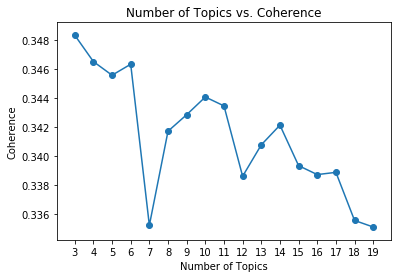

In [39]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

*4.1. The LDA model with the proposed number of k topics based on the coherence and perplexity estimations:*

In [ ]:
SOME_FIXED_SEED = 42

# before training/inference:
np.random.seed(SOME_FIXED_SEED)


In [146]:
# # Let's try 10, 8, and 6 topics
num_topics = 6
lda_model = LdaModel(corpus=gensim_corpus,
                    id2word=dictionary,
                    alpha='auto',
                    eta='auto',
                    num_topics=num_topics,
                    per_word_topics = True,
                    )

In [44]:
# coherencemodel = CoherenceModel(model=lda_model_2, texts=wb_lyrics_spacy_lemmas, dictionary=dictionary, coherence='c_v')
# print(coherencemodel.get_coherence())

In [49]:
coherencemodel = CoherenceModel(model=lda_model, texts=wb_lyrics_spacy_lemmas, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.36510666566424504


In [49]:
topic_data = pyLDAvis.gensim_models.prepare(lda_model, gensim_corpus, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

In [51]:
all_topics = {}
num_terms = 20 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,7): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [57]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,love,never,feel,heart,say,see,make,want,need,try,give,believe,life,always,think,time,let,one,ever,hold
Topic 2,kill,man,dead,black,cut,head,war,eat,red,big,kid,fucking,blood,gun,white,sell,hate,die,drink,people
Topic 3,light,world,sky,soul,burn,sun,eye,fire,dream,sing,rise,fall,shine,rain,star,night,fear,dark,life,fly
Topic 4,go,back,come,time,home,day,away,take,long,run,way,say,turn,wait,night,walk,around,leave,move,stay
Topic 5,baby,girl,wanna,little,want,good,like,boy,make,right,tonight,shake,need,crazy,bad,woman,tell,pretty,really,thing
Topic 6,shit,fuck,bitch,nigga,rock,ass,hit,money,wit,niggaz,niggas,hoe,beat,game,roll,pop,club,hot,block,stop


1. Love and Emotions
2. Violence and Darkness
3. Spiritual and Dreamy 
4. Movement and Change
5. Passion and Desire
6. Profanity and Aggression

In [129]:
import pandas as pd

data = {
    'Love and Care': ["love", "never", "feel", "heart", "say", "see", "make", "want", "need", "try", "give", "believe", "life", "always", "think", "time", "let", "one", "ever", "hold"],
    'Violence and Harm': ["kill", "man", "dead", "black", "cut", "head", "war", "eat", "red", "big", "kid", "fucking", "blood", "gun", "white", "sell", "hate", "die", "drink", "people"],
    'Spiritual and Dreamy': ["light", "world", "sky", "soul", "burn", "sun", "eye", "fire", "dream", "sing", "rise", "fall", "shine", "rain", "star", "night", "fear", "dark", "life", "fly"],
    'Movement and Change': ["go", "back", "come", "time", "home", "day", "away", "take", "long", "run", "way", "say", "turn", "wait", "night", "walk", "around", "leave", "move", "stay"],
    'Lust and Desire': ["baby", "girl", "wanna", "little", "want", "good", "like", "boy", "make", "right", "tonight", "shake", "need", "crazy", "bad", "woman", "tell", "pretty", "really", "thing"],
    'Profanity and Aggression': ["shit", "fuck", "bitch", "nigga", "rock", "ass", "hit", "money", "wit", "niggaz", "niggas", "hoe", "beat", "game", "roll", "pop", "club", "hot", "block", "stop"]
}

topic_df = pd.DataFrame(data)
topic_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Love and Care,love,never,feel,heart,say,see,make,want,need,try,give,believe,life,always,think,time,let,one,ever,hold
Violence and Harm,kill,man,dead,black,cut,head,war,eat,red,big,kid,fucking,blood,gun,white,sell,hate,die,drink,people
Spiritual and Dreamy,light,world,sky,soul,burn,sun,eye,fire,dream,sing,rise,fall,shine,rain,star,night,fear,dark,life,fly
Movement and Change,go,back,come,time,home,day,away,take,long,run,way,say,turn,wait,night,walk,around,leave,move,stay
Lust and Desire,baby,girl,wanna,little,want,good,like,boy,make,right,tonight,shake,need,crazy,bad,woman,tell,pretty,really,thing
Profanity and Aggression,shit,fuck,bitch,nigga,rock,ass,hit,money,wit,niggaz,niggas,hoe,beat,game,roll,pop,club,hot,block,stop


In [131]:
latex_code = topic_df.to_latex()
print(latex_code)


\begin{tabular}{lllllll}
\toprule
 & Love and Care & Violence and Harm & Spiritual and Dreamy & Movement and Change & Lust and Desire & Profanity and Aggression \\
\midrule
0 & love & kill & light & go & baby & shit \\
1 & never & man & world & back & girl & fuck \\
2 & feel & dead & sky & come & wanna & bitch \\
3 & heart & black & soul & time & little & nigga \\
4 & say & cut & burn & home & want & rock \\
5 & see & head & sun & day & good & ass \\
6 & make & war & eye & away & like & hit \\
7 & want & eat & fire & take & boy & money \\
8 & need & red & dream & long & make & wit \\
9 & try & big & sing & run & right & niggaz \\
10 & give & kid & rise & way & tonight & niggas \\
11 & believe & fucking & fall & say & shake & hoe \\
12 & life & blood & shine & turn & need & beat \\
13 & always & gun & rain & wait & crazy & game \\
14 & think & white & star & night & bad & roll \\
15 & time & sell & night & walk & woman & pop \\
16 & let & hate & fear & around & tell & club \\
17 & one &

#### 5. Save the LDA model:

In [54]:
# with open("LDA_Models/wasabi_lyrics_lda_model.pk","wb") as f:
#     pickle.dump(lda_model, f)

*5.1.Read the best LDA model that we hace saved:*

#### 7. The Dominant topic and its percentage contribution in each Lyrics
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The code below extracts the dominant topic for each lyrics and shows the weight of the topic and the keywords in a nicely formatted output. This way, we will know which lyrics belongs predominantly to which topic.

In [28]:
def format_topics_lyrics(ldamodel=None, corpus=gensim_corpus, texts=wb_lyrics_spacy_lemmas):    
    lyrics_topics_dt = pd.DataFrame()

    # Get main topic in each lyrics
    for i, row_list in tqdm(enumerate(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list # assign weights per each lyrics rows          
      
        row = sorted(row, key=lambda x: (x[1]), reverse=True) #sorted rows based on the weights
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row): # topic num and propability
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num) # ('word', topic_pribablity)
                topic_keywords = ", ".join([word for word, prop in wp]) # join keywords per topic
                lyrics_topics_dt = lyrics_topics_dt.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    lyrics_topics_dt.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    lyrics_topics_dt = pd.concat([lyrics_topics_dt, contents], axis=1) #column wise
    return(lyrics_topics_dt)

In [59]:
topic_lyrics_keywords_dt = format_topics_lyrics(ldamodel = lda_model, 
                                                corpus = gensim_corpus, 
                                                texts = wb_lyrics_spacy_lemmas)

377812it [43:10, 145.87it/s]


In [60]:
# Let's save the data in a pickle file
# topic_lyrics_keywords_dt.to_pickle("topic_lyrics_keywords_dt_1.pkl")  

In [29]:
import pickle

# Replace 'your_file.pkl' with the actual path to your pickle file
file_path = 'topic_lyrics_keywords_dt.pkl'

# Read the pickle file
with open(file_path, 'rb') as file:
    topic_lyrics_keywords_dt = pickle.load(file)

# Now, 'data' contains the content of your pickle file

In [30]:
topic_lyrics_keywords_dt

,dominant_topic,perc_contribution,topic_keywords,0
0,2.0,0.3078,"world, light, come, eye, see, life, night, fal...","[buy, wonderful, morning, sky, never, see, tie..."
1,2.0,0.7440,"world, light, come, eye, see, life, night, fal...","[see, sun, see, glow, see, rain, turn, snow, s..."
2,1.0,0.3043,"go, come, time, back, day, take, say, away, wa...","[turn, gray, sky, blue, see, make, rain, want,..."
3,0.0,0.4756,"love, never, feel, say, see, make, want, time,...","[lonely, baby, lonely, baby, last, train, baby..."
4,0.0,0.6122,"love, never, feel, say, see, make, want, time,...","[trouble, cry, remember, stand, thank, heartac..."
...,...,...,...,...
377807,0.0,0.3638,"love, never, feel, say, see, make, want, time,...","[look, madness, control, feed, sadness, eat, s..."
377808,0.0,0.5551,"love, never, feel, say, see, make, want, time,...","[word, kill, fear, part, agenda, feel, shake, ..."
377809,0.0,0.7262,"love, never, feel, say, see, make, want, time,...","[life, change, many, way, say, People, everywh..."
377810,0.0,0.4607,"love, never, feel, say, see, make, want, time,...","[alone, tell, tell, life, put, sun, tell, burn..."


7.1. Format dominant keyword dataframe

In [31]:
dominant_topic_dt = topic_lyrics_keywords_dt.reset_index()
dominant_topic_dt.columns = ['document_no', 'dominant_topic', 'topic_contrib', 'keywords', 'lyrics']
dominant_topic_dt.reset_index(drop = True, inplace = True)
dominant_topic_dt[:10]

,document_no,dominant_topic,topic_contrib,keywords,lyrics
0,0,2.0,0.3078,"world, light, come, eye, see, life, night, fal...","[buy, wonderful, morning, sky, never, see, tie..."
1,1,2.0,0.7440,"world, light, come, eye, see, life, night, fal...","[see, sun, see, glow, see, rain, turn, snow, s..."
2,2,1.0,0.3043,"go, come, time, back, day, take, say, away, wa...","[turn, gray, sky, blue, see, make, rain, want,..."
3,3,0.0,0.4756,"love, never, feel, say, see, make, want, time,...","[lonely, baby, lonely, baby, last, train, baby..."
4,4,0.0,0.6122,"love, never, feel, say, see, make, want, time,...","[trouble, cry, remember, stand, thank, heartac..."
5,5,0.0,0.3703,"love, never, feel, say, see, make, want, time,...","[tired, alone, tired, help, girl, soon, People..."
6,6,1.0,0.6642,"go, come, time, back, day, take, say, away, wa...","[drive, drive, ram, keep, pushin, baby, next, ..."
7,7,1.0,0.5878,"go, come, time, back, day, take, say, away, wa...","[baby, work, rob, steal, baby, work, rob, stea..."
8,8,2.0,0.4756,"world, light, come, eye, see, life, night, fal...","[untrue, liar, come, say, girl, much, high, li..."
9,9,4.0,0.3749,"baby, girl, want, wanna, good, little, make, l...","[say, able, sing, man, say, able, sing, man, a..."


In [37]:
dominant_topic_dt.dominant_topic.value_counts()

0.0    133345
2.0     78844
5.0     69294
1.0     56806
4.0     22820
3.0     16703
Name: dominant_topic, dtype: int64

*7.2. Let's add the topics to the rest of lyrics emotions and sentiment dataframe:*

#### 8. Concatenate the artist lyrics features dataset with the extracted topics: 

In [38]:
wb_song_lyrics_dt = pd.concat([song_lyrics, dominant_topic_dt[['dominant_topic','topic_contrib', 'keywords']]], axis = 1)

Now we change the names of the topics in the songs (For the version 1):

In [40]:
wb_song_lyrics_dt['dominant_topic'] = wb_song_lyrics_dt['dominant_topic'].replace(0.0, 'Love and Emotions')
wb_song_lyrics_dt['dominant_topic'] = wb_song_lyrics_dt['dominant_topic'].replace(1.0, 'Movement and Change')
wb_song_lyrics_dt['dominant_topic'] = wb_song_lyrics_dt['dominant_topic'].replace(2.0, 'Spiritual and Dreamy')
wb_song_lyrics_dt['dominant_topic'] = wb_song_lyrics_dt['dominant_topic'].replace(3.0, 'Profanity and Aggression')
wb_song_lyrics_dt['dominant_topic'] = wb_song_lyrics_dt['dominant_topic'].replace(4.0, 'Passion and Desire')
wb_song_lyrics_dt['dominant_topic'] = wb_song_lyrics_dt['dominant_topic'].replace(5.0, 'Violence and Darkness')

In [42]:
# wb_song_lyrics_dt[wb_song_lyrics_dt['dominant_topic']== 'Death Fear and Violence']

#### Now we apply one hot encoding for the topics:

In [41]:
one_hot_encoded_genre_topis = pd.get_dummies(
     wb_song_lyrics_dt['dominant_topic'], prefix= None)
one_hot_encoded_genre_topis

,Love and Emotions,Movement and Change,Passion and Desire,Profanity and Aggression,Spiritual and Dreamy,Violence and Darkness
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
377807,1,0,0,0,0,0
377808,1,0,0,0,0,0
377809,1,0,0,0,0,0
377810,1,0,0,0,0,0


#### Now we concatenate this with the rest of the data audio and information:

In [42]:
wb_song_lyrics_dt.reset_index(drop = True, inplace = True)
one_hot_encoded_genre_topis.reset_index(drop = True, inplace = True)

wb_song_lyrics_dt = pd.concat([wb_song_lyrics_dt, one_hot_encoded_genre_topis], axis = 1)

In [12]:
wb_song_lyrics_dt_ = wb_song_lyrics_dt[wb_song_lyrics_dt['artist_type']=='Person']

In [13]:
wb_song_lyrics_dt_.reset_index(drop  = True, inplace = True)

In [51]:
passion_songs = wb_song_lyrics_dt_[wb_song_lyrics_dt_['Passion and Desire'] == 1].nlargest(100, 'topic_contrib')
love_songs = wb_song_lyrics_dt_[wb_song_lyrics_dt_['Love and Emotions']==1].nlargest(100, 'topic_contrib')
change_songs = wb_song_lyrics_dt_[wb_song_lyrics_dt_['Movement and Change']==1].nlargest(100, 'topic_contrib')
profanity_songs = wb_song_lyrics_dt_[wb_song_lyrics_dt_['Profanity and Aggression']==1].nlargest(100, 'topic_contrib')
spiritual_songs = wb_song_lyrics_dt_[wb_song_lyrics_dt_['Spiritual and Dreamy']==1].nlargest(100, 'topic_contrib')
violence_songs = wb_song_lyrics_dt_[wb_song_lyrics_dt_['Violence and Aggression']==1].nlargest(100, 'topic_contrib')

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette("hls", 8)

In [85]:
wb_song_lyrics_dt.dominant_topic.value_counts()

dominant_topic
Love and Emotions           133345
Spiritual and Dreamy         78844
Violence and Darkness        69294
Movement and Change          56806
Passion and Desire           22820
Profanity and Aggression     16703
Name: count, dtype: int64

Text(0.5, 1.0, 'Lyrics Topics')

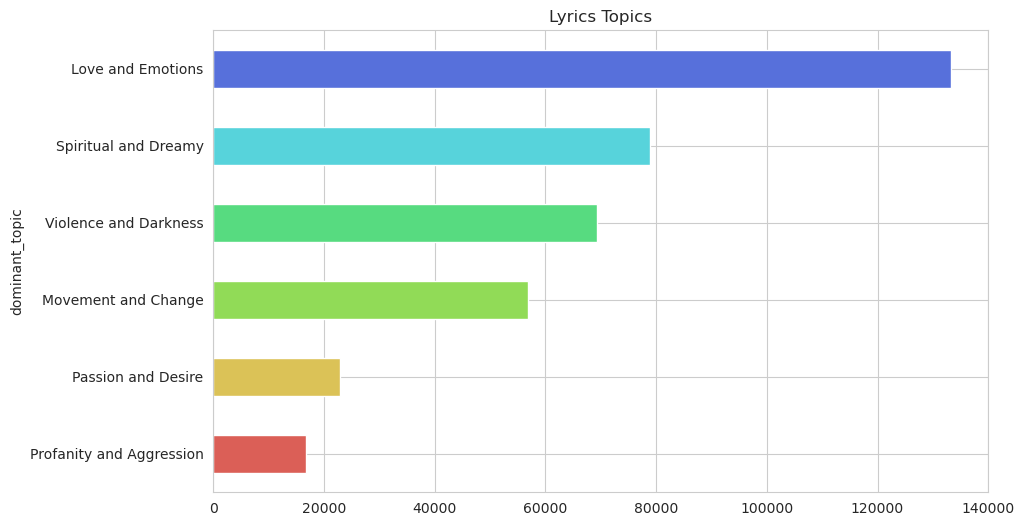

In [86]:
wb_song_lyrics_dt.dominant_topic.value_counts().sort_values(ascending = True).plot(kind = 'barh', color=colors, figsize= (10,6))
plt.title('Lyrics Topics')

1. Important info to have in the papre: The weights of the topics and the weights of the lemmas in the topics.

#### 10. References:
1. Temporal Analysis and Visualisation of Music (Misael et al 2020): https://sol.sbc.org.br/index.php/eniac/article/view/12155
2. Evaluate Topic Models: Latent Dirichlet Allocation (LDA): https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
3. What’s in a Song? LDA Topic Modeling of over 120,000 Lyrics:
https://tim-denzler.medium.com/whats-in-a-song-using-lda-to-find-topics-in-over-120-000-songs-53785767b692
4. Evaluation of Topic Modeling: Topic Coherence: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/